<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 2
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

# Setup

Firstly let's install and upgrade the necessary packages

In [1]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00


Let's import all the necessary functions and packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from dl_utils import plot_history
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score


Check the versions of the packages

In [6]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


Check the runtime device

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Load data

Load the training and test set and display its shape

In [8]:
import gdown
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Google Drive file ID of your zip file
file_id = '18j4OvAlNWX9pfaoiJNgcTEVslksaf4Dw'
# URL for downloading the file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
# Destination path for the downloaded zip file (in Google Colab)
zip_file_path = '/content/file.zip'
# Download the file
gdown.download(url, zip_file_path, quiet=False)
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_folder')

# Define the paths for X and y
X = []
y = []

# Iterate through the extracted folder
for root, dirs, files in os.walk('/content/extracted_folder/images'):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)

        # Iterate through images in each folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Load the image and convert it to numpy array if needed
            img = Image.open(image_path)
            img_array = np.array(img)
            X.append(img)
            y.append(folder_name)

# Convert y to numerical labels using LabelEncoder from sklearn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Resizing all the images
resized_images = []
# Define the target size
width = 50
height = 50
target_size = (width, height)

# Resize each image to the target size using LANCZOS resampling
for img in X:
    resized_img = img.resize(target_size, Image.LANCZOS)
    resized_images.append(resized_img)
# Convert the list of resized images to a NumPy array
X_array = np.array([np.array(img) for img in resized_images])

Downloading...
From (original): https://drive.google.com/uc?id=18j4OvAlNWX9pfaoiJNgcTEVslksaf4Dw
From (redirected): https://drive.google.com/uc?id=18j4OvAlNWX9pfaoiJNgcTEVslksaf4Dw&confirm=t&uuid=c897f4eb-05c3-46a5-ac7d-532d404e8ceb
To: /content/file.zip
100%|██████████| 239M/239M [00:00<00:00, 259MB/s]


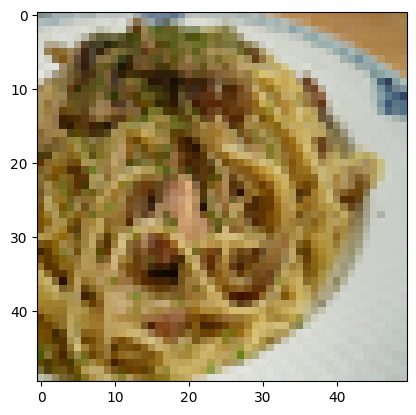

[1 1 1 ... 3 3 3]


In [9]:
# Display the first resized image
plt.imshow(X_array[1000])
plt.show()
print(y)

In [10]:
SEED=33
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.2, random_state=SEED)

Preprocess the feature vectors (normalize data)

In [11]:
# Input data preprocessing
print(np.min(X_train), np.max(y_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

#normalization
X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 4
1154 train samples
289 test samples


Preprocess the labels (one-hot encodings)

In [12]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 4
First label is now =  [0. 0. 1. 0. 0.]


## Validation data
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance.

In [13]:
# Split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED) # for reproducibility